In [1]:
!pip install pandas numpy matplotlib seaborn plotly

In [3]:
!pip install geopandas folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.4/338.4 kB 5.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 17.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 13.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.7 MB/s eta 0:00:00a 0:00:01


In [1]:
import pandas as pd  ## importing neccessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')

In [3]:
pd.set_option('display.max_columns', None)  # setting up display option
pd.set_option('display.max_rows', 200)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

In [5]:
listings = pd.read_csv("../Raw_Data/listings.csv") #loading dataset
calendar = pd.read_csv("../Raw_Data/calendar.csv")
reviews = pd.read_csv("../Raw_Data/reviews.csv")

In [7]:
listings.head()
calendar.head()
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2708,13994902,2014-06-09,10905424,Kuberan,i had a wonderful stay. Everything from start ...
1,2708,14606598,2014-06-23,2247288,Camilla,Charles is just amazing and he made my stay sp...
2,2708,39597339,2015-07-25,27974696,Fallon,Staying with Chas was an absolute pleasure. He...
3,2708,61157407,2016-02-01,33226412,Haroon,Charles is a most wonderful host. I enjoyed my...
4,2708,66196280,2016-03-20,23408691,Massimo Litterio,Chas is a really good host. He gives me a lot ...


In [9]:
listings.info() # inspecting raw data
calendar.info()
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45886 entries, 0 to 45885
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            45886 non-null  int64  
 1   listing_url                                   45886 non-null  object 
 2   scrape_id                                     45886 non-null  int64  
 3   last_scraped                                  45886 non-null  object 
 4   source                                        45886 non-null  object 
 5   name                                          45885 non-null  object 
 6   description                                   44917 non-null  object 
 7   neighborhood_overview                         19936 non-null  object 
 8   picture_url                                   45886 non-null  object 
 9   host_id                                       45886 non-null 

# Cleaning Listings.csv

In [12]:
# converting date columns

date_cols = ['last_scraped', 'calendar_last_scraped', 'first_review', 'last_review', 'host_since']

for col in date_cols:
    if col in listings.columns:
        listings[col] = pd.to_datetime(listings[col], errors='coerce')

In [14]:
# flitering to only 2025

listings_2025 = listings[
    (listings['last_scraped'].dt.year == 2025)
]

In [16]:
# cleaning currency columns

def clean_currency(col):
    return (
        col.astype(str)
           .str.replace(r'[$,]', '', regex=True)
           .replace(r'nan|None|NULL', np.nan, regex=True)
           .astype(float)
    )

currency_cols = [
    'price','weekly_price','monthly_price',
    'cleaning_fee','security_deposit','extra_people'
]

for col in currency_cols:
    if col in listings_2025.columns:
        listings_2025[col] = clean_currency(listings_2025[col])

In [18]:
# Cleaning boolean

bool_cols = ['host_is_superhost','host_has_profile_pic','host_identity_verified',
             'instant_bookable','has_availability']

for col in bool_cols:
    if col in listings_2025.columns:
        listings_2025[col] = listings_2025[col].map({'t': True, 'f': False})

In [20]:
# Cleaning text fields

import re

text_cols = ['description','neighborhood_overview','host_about','name']

def clean_text(text):
    if pd.isna(text):
        return ""
    # remove html breaks
    text = re.sub(r'<br\s*/?>', ' ', text)
    # normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

for col in text_cols:
    if col in listings_2025.columns:
        listings_2025[col] = listings_2025[col].apply(clean_text)

In [22]:
# Cleaning amenities

import ast

def clean_amenities(a):
    try:
        a = ast.literal_eval(a)
        return [x.strip().lower() for x in a]
    except:
        return []

listings_2025['amenities_list'] = listings_2025['amenities'].apply(clean_amenities)
listings_2025['amenities_count'] = listings_2025['amenities_list'].apply(len)

In [24]:
# Drop duplicates

listings_2025 = listings_2025.drop_duplicates(subset='id')

# Cleaning Calendar.csv

In [27]:
# Convert types

calendar['date'] = pd.to_datetime(calendar['date'], errors='coerce')
calendar['available'] = calendar['available'].map({'t': True, 'f': False})

In [29]:
# Filter only 2025

calendar_2025 = calendar[calendar['date'].dt.year == 2025]

# Cleaning Reviews.csv

In [32]:
# convert date

reviews['date'] = pd.to_datetime(reviews['date'], errors='coerce')

In [34]:
# Filter 2025

reviews_2025 = reviews[reviews['date'].dt.year == 2025].copy()

In [36]:
# Clean reviewer name + comments

reviews_2025['reviewer_name'] = reviews_2025['reviewer_name'].fillna("Unknown")

reviews_2025['comments'] = (
    reviews_2025['comments']
      .astype(str)
      .str.replace(r'<br\s*/?>', ' ', regex=True)
      .str.replace(r'\s+', ' ', regex=True)
      .str.strip()
)

In [38]:
listings_2025.to_csv("../Clean_Data/listings_2025_clean.csv", index=False)
calendar_2025.to_csv("../Clean_Data/calendar_2025_clean.csv", index=False)
reviews_2025.to_csv("../Clean_Data/reviews_2025_clean.csv", index=False)

# Feature Engineering

In [41]:
# Listings

import pandas as pd
import numpy as np

# -----------------------
# 1. WORK WITH LISTINGS
# -----------------------

# Filter year = 2025
listings_2025 = listings[listings['calendar_last_scraped'].dt.year == 2025].copy()

# Clean price columns ($1,234 → 1234)
price_cols = ["price", "weekly_price", "monthly_price"]

for col in price_cols:
    if col in listings_2025.columns:
        listings_2025[col] = (
            listings_2025[col]
            .astype(str)
            .str.replace("$", "", regex=False)
            .str.replace(",", "", regex=False)
        )
        listings_2025[col] = pd.to_numeric(listings_2025[col], errors="coerce")


# -----------------------
# 2. CALCULATE FEATURES
# -----------------------

# Estimated occupancy rate (based on Airbnb's availability fields)
listings_2025["occupancy_rate"] = (
    1 - (listings_2025["availability_365"] / 365)
).round(3)

# Estimated revenue using Airbnb formula
listings_2025["estimated_revenue"] = (
    listings_2025["price"] * listings_2025["occupancy_rate"] * 365
).round(2)

# Rating average
rating_cols = [
    "review_scores_rating", 
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_location",
    "review_scores_communication",
    "review_scores_checkin",
    "review_scores_value"
]

listings_2025["avg_rating"] = listings_2025[rating_cols].mean(axis=1)

# -----------------------
# 3. KEEP FINAL IMPORTANT COLUMNS
# -----------------------

listings_2025_clean = listings_2025[
    [
        "id",
        "listing_url",
        "name",
        "host_id",
        "host_name",
        "neighbourhood_cleansed",
        "property_type",
        "room_type",
        "accommodates",
        "price",
        "occupancy_rate",
        "estimated_revenue",
        "avg_rating",
        "number_of_reviews",
        "reviews_per_month",
        "availability_365",
    ]
]

In [43]:
# Calendar

# -----------------------
# 1. FILTER TO 2025
# -----------------------
calendar_2025 = calendar[calendar["date"].dt.year == 2025].copy()

# Convert availability t/f → 1/0
calendar_2025["available_flag"] = calendar_2025["available"].map({"t": 1, "f": 0})

# Convert price columns 
for col in ["price", "adjusted_price"]:
    calendar_2025[col] = (
        calendar_2025[col]
        .astype(str)
        .str.replace("$", "", regex=False)
        .str.replace(",", "", regex=False)
    )
    calendar_2025[col] = pd.to_numeric(calendar_2025[col], errors="coerce")


# -----------------------
# 2. CALCULATE FEATURES
# -----------------------

# Occupied nights = 1 - available_flag
calendar_2025["occupied_flag"] = 1 - calendar_2025["available_flag"]

# Revenue per night
calendar_2025["night_revenue"] = (
    calendar_2025["occupied_flag"] * calendar_2025["price"]
)

In [45]:
# Reviews

# -----------------------
# 1. FILTER TO 2025
# -----------------------
reviews_2025 = reviews[reviews["date"].dt.year == 2025].copy()

# Add review length feature
reviews_2025["comment_length"] = reviews_2025["comments"].str.len()

# Add sentiment proxy (basic)
reviews_2025["sentiment_flag"] = reviews_2025["comments"].str.contains(
    "great|amazing|clean|perfect|love|excellent|wonderful|friendly",
    case=False,
    na=False
).astype(int)

In [47]:
listings_2025_clean.to_csv("../Clean_Data/listings_2025_clean.csv", index=False)
calendar_2025_clean = calendar_2025.copy()
calendar_2025_clean.to_csv("../Clean_Data/calendar_2025_clean.csv", index=False)
reviews_2025_clean = reviews_2025.copy()
reviews_2025_clean.to_csv("../Clean_Data/reviews_2025_clean.csv", index=False)

# STAR schema

In [50]:
dim_listing = listings_2025_clean[[
    "id",
    "host_id",
    "host_name",
    "neighbourhood_cleansed",
    "property_type",
    "room_type",
    "accommodates",
    "price",
    "avg_rating",
    "number_of_reviews",
    "availability_365"
]].drop_duplicates()

# Rename id → listing_id for consistency
dim_listing.rename(columns={"id": "listing_id"}, inplace=True)

dim_listing.to_csv("../Clean_Data/dim_listing.csv", index=False)

In [52]:
import pandas as pd

dim_date = pd.DataFrame({
    "date": pd.date_range("2025-01-01", "2025-12-31")
})

dim_date["year"] = dim_date["date"].dt.year
dim_date["quarter"] = dim_date["date"].dt.quarter
dim_date["month"] = dim_date["date"].dt.month
dim_date["month_name"] = dim_date["date"].dt.month_name()
dim_date["week"] = dim_date["date"].dt.isocalendar().week
dim_date["day"] = dim_date["date"].dt.day
dim_date["day_of_week"] = dim_date["date"].dt.day_name()

dim_date.to_csv("../Clean_Data/dim_date.csv", index=False)

In [54]:
fact_calendar = calendar_2025_clean.copy()

# Convert available → occupancy (1 = booked, 0 = available)
fact_calendar["occupancy_flag"] = fact_calendar["available"].map({"t": 1, "f": 0})

# Revenue = price only if booked
fact_calendar["revenue"] = fact_calendar["price"] * fact_calendar["occupancy_flag"]

fact_calendar = fact_calendar[[
    "listing_id",
    "date",
    "price",
    "available",
    "occupancy_flag",
    "revenue",
    "minimum_nights",
    "maximum_nights"
]]

fact_calendar.to_csv("../Clean_Data/fact_calendar.csv", index=False)

In [56]:
reviews_2025_clean["review_length"] = reviews_2025_clean["comments"].str.len()

fact_reviews = reviews_2025_clean[[
    "id",
    "listing_id",
    "date",
    "reviewer_id",
    "reviewer_name",
    "comments",
    "review_length"
]].copy()

fact_reviews.rename(columns={"id": "review_id"}, inplace=True)

fact_reviews.to_csv("../Clean_Data/fact_reviews.csv", index=False)

# Calculating KPI's

1. What listing attributes influence price & occupancy?
2. Which neighborhoods have the highest demand?

In [59]:
# Total Revenue per Listing

# Convert if needed
fact_calendar['available'] = fact_calendar['available'].replace({'t': 1, 'f': 0})

# Occupancy calculation
occupancy_per_listing = fact_calendar.groupby("listing_id")["available"].apply(lambda x: 1 - x.mean()).reset_index()
occupancy_per_listing.columns = ["listing_id", "occupancy_rate"]

occupancy_per_listing.head()

,listing_id,occupancy_rate
0,2708,0.03
1,2732,0.76
2,2864,1.00
3,6033,1.00
4,6931,0.62


In [61]:
# Estimated Revenue per Listing

# Booked nights count
booked_nights = fact_calendar[fact_calendar['available'] == 0].groupby("listing_id")["date"].count().reset_index()
booked_nights.columns = ["listing_id", "booked_nights"]

# Listing price
listing_price = listings_2025_clean[["id", "price"]].copy()
listing_price.rename(columns={"id": "listing_id"}, inplace=True)

# Merge and calculate revenue
revenue_per_listing = booked_nights.merge(listing_price, on="listing_id", how="left")
revenue_per_listing["estimated_revenue"] = revenue_per_listing["booked_nights"] * revenue_per_listing["price"]

revenue_per_listing.head()

,listing_id,booked_nights,price,estimated_revenue
0,2708,4,81.00,324.00
1,2732,91,110.00,"10,010.00"
2,2864,120,NaN,NaN
3,6033,120,NaN,NaN
4,6931,74,88.00,"6,512.00"


In [63]:
# Average Daily Rate (ADR)

revenue_per_listing["adr"] = revenue_per_listing["estimated_revenue"] / revenue_per_listing["booked_nights"]
revenue_per_listing.head()

,listing_id,booked_nights,price,estimated_revenue,adr
0,2708,4,81.00,324.00,81.00
1,2732,91,110.00,"10,010.00",110.00
2,2864,120,NaN,NaN,NaN
3,6033,120,NaN,NaN,NaN
4,6931,74,88.00,"6,512.00",88.00


In [65]:
# Combine Occupancy + Revenue + ADR

kpi_listing = listings_2025_clean.merge(occupancy_per_listing, left_on="id", right_on="listing_id", how="left")
kpi_listing = kpi_listing.merge(revenue_per_listing[["listing_id", "estimated_revenue", "adr"]], on="listing_id", how="left")

kpi_listing.head()

kpi_listing.to_csv("../Clean_Data/kpi_listing.csv", index=False)

In [67]:
# Neighborhood-Level Occupancy & Demand

neighborhood_occupancy = (
    kpi_listing
    .groupby("neighbourhood_cleansed")["occupancy_rate_y"]
    .mean()
    .reset_index()
    .sort_values(by="occupancy_rate_y", ascending=False)
)

neighborhood_occupancy.head()

,neighbourhood_cleansed,occupancy_rate_y
229,Val Verde,1.00
202,South Diamond Bar,1.00
72,Elizabeth Lake,0.75
99,Hidden Hills,0.74
248,West Compton,0.66


In [69]:
# Neighborhood-Level Revenue

neighborhood_revenue = (
    kpi_listing
    .groupby("neighbourhood_cleansed")["estimated_revenue_y"]
    .sum()
    .reset_index()
    .sort_values(by="estimated_revenue_y", ascending=False)
)

neighborhood_revenue.head()

,neighbourhood_cleansed,estimated_revenue_y
251,West Hollywood,"35,888,966.00"
132,Long Beach,"18,854,565.00"
234,Venice,"14,305,791.00"
25,Beverly Hills,"13,906,441.00"
104,Hollywood Hills West,"12,648,272.00"


# VISUALIZATIONS

/var/folders/zr/6bnh4lhn4cvcn912n27dmpxw0000gn/T/ipykernel_9127/1607205222.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


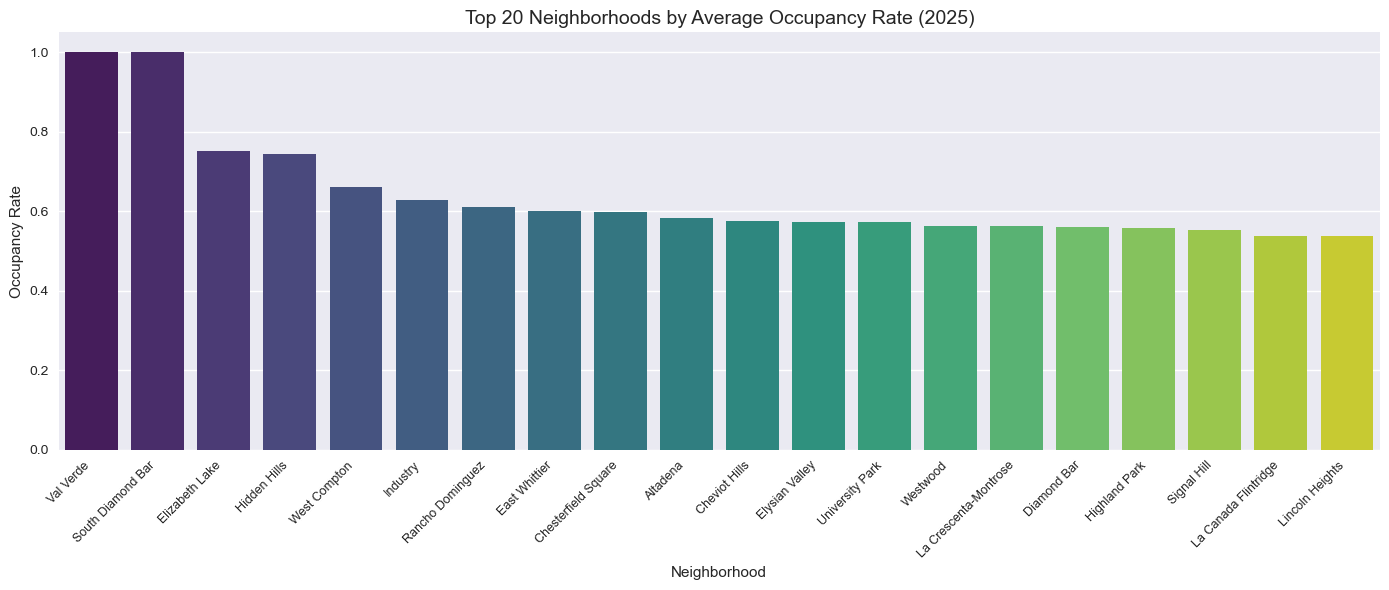

In [72]:
# Occupancy by Neighborhood

# ---- TOP 20 NEIGHBORHOODS BY OCCUPANCY RATE ----

# 1. Sort and select top 20
top20_neighborhoods = (
    neighborhood_occupancy
    .sort_values(by="occupancy_rate_y", ascending=False)
    .head(20)
)

# 2. Plot
plt.figure(figsize=(14,6))
sns.barplot(
    data=top20_neighborhoods,
    x="neighbourhood_cleansed",
    y="occupancy_rate_y",
    palette="viridis"
)

# 3. Labels
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.title("Top 20 Neighborhoods by Average Occupancy Rate (2025)", fontsize=14)
plt.ylabel("Occupancy Rate")
plt.xlabel("Neighborhood")
plt.tight_layout()

plt.show()

/var/folders/zr/6bnh4lhn4cvcn912n27dmpxw0000gn/T/ipykernel_9127/3935862825.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


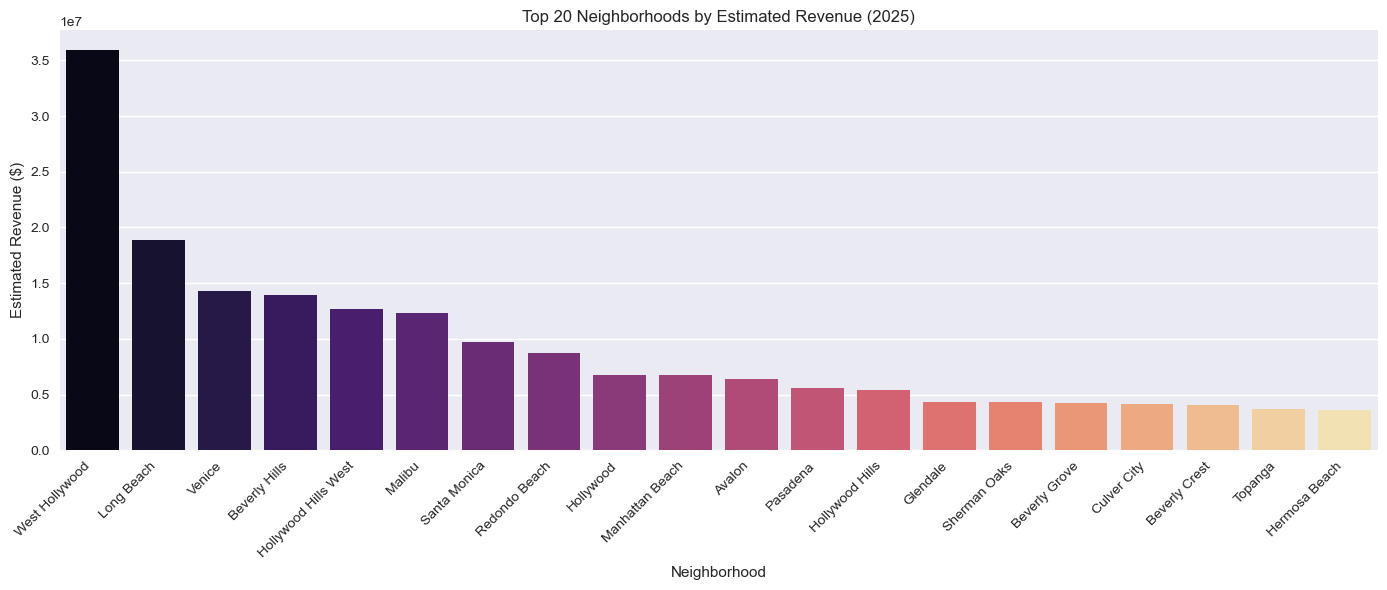

In [74]:
# Top 20 Neighborhoods by Revenue

# Sort revenue
top20_revenue = (
    neighborhood_revenue
    .sort_values(by="estimated_revenue_y", ascending=False)
    .head(20)
)

plt.figure(figsize=(14,6))
sns.barplot(
    data=top20_revenue,
    x="neighbourhood_cleansed",
    y="estimated_revenue_y",
    palette="magma"
)
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Neighborhoods by Estimated Revenue (2025)")
plt.ylabel("Estimated Revenue ($)")
plt.xlabel("Neighborhood")
plt.tight_layout()
plt.show()

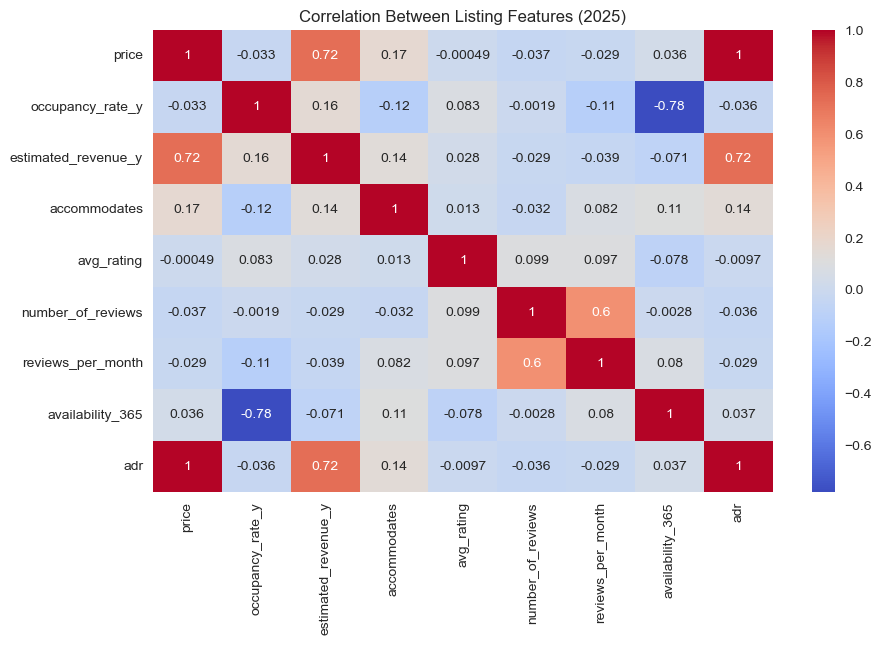

In [76]:
#Feature Importance (Correlation Heatmap)

corr_features = kpi_listing[[
    "price",
    "occupancy_rate_y",
    "estimated_revenue_y",
    "accommodates",
    "avg_rating",
    "number_of_reviews",
    "reviews_per_month",
    "availability_365",
    "adr"
]]

correlation_matrix = corr_features.corr()
correlation_matrix

plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Between Listing Features (2025)")
plt.show()

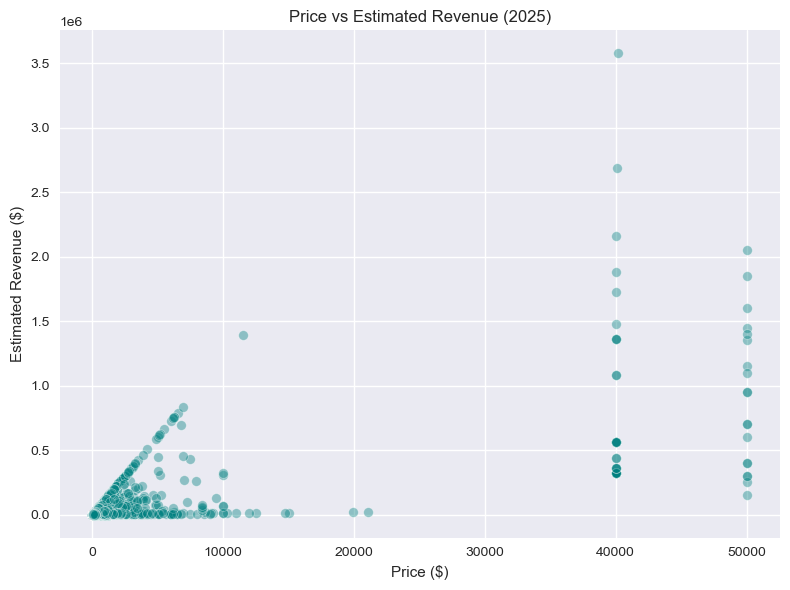

In [78]:
# Scatter Plot - Price vs Estimated Revenue

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=kpi_listing,
    x="price",
    y="estimated_revenue_y",
    alpha=0.4,
    color="teal"
)

plt.title("Price vs Estimated Revenue (2025)")
plt.xlabel("Price ($)")
plt.ylabel("Estimated Revenue ($)")
plt.tight_layout()
plt.show()

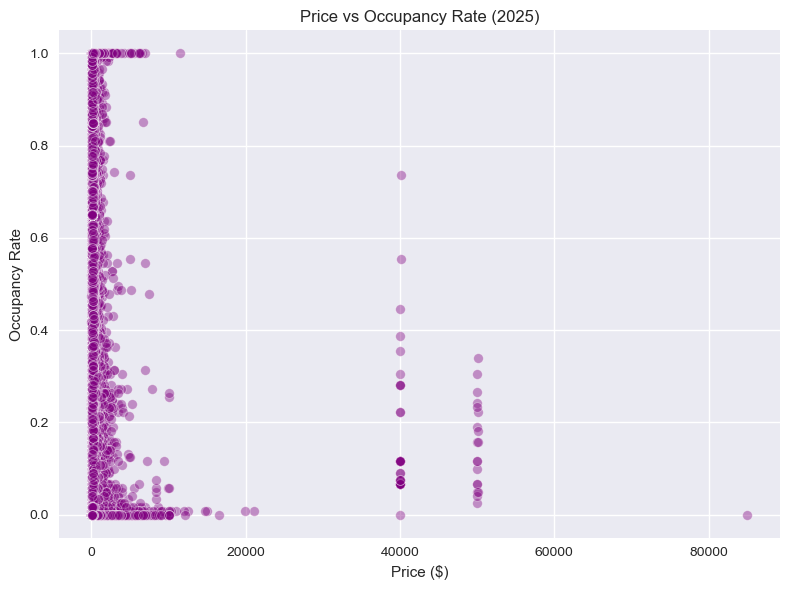

In [80]:
# Scatter Plot — Price vs Occupancy Rate

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=kpi_listing,
    x="price",
    y="occupancy_rate_y",
    alpha=0.4,
    color="purple"
)

plt.title("Price vs Occupancy Rate (2025)")
plt.xlabel("Price ($)")
plt.ylabel("Occupancy Rate")
plt.tight_layout()
plt.show()

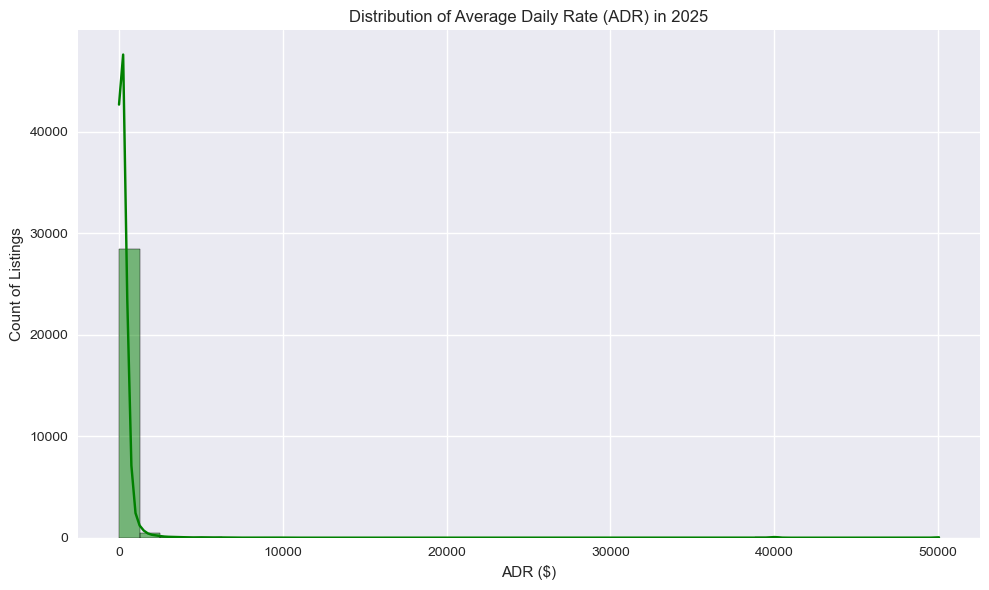

In [82]:
# Distribution of ADR (Average Daily Rate)

plt.figure(figsize=(10,6))
sns.histplot(
    kpi_listing["adr"],
    bins=40,
    kde=True,
    color="green"
)

plt.title("Distribution of Average Daily Rate (ADR) in 2025")
plt.xlabel("ADR ($)")
plt.ylabel("Count of Listings")
plt.tight_layout()
plt.show()